In [ ]:
# Install Java, Spark, and Findspark
!apt-get update
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
!wget -q http://www-us.apache.org/dist/spark/spark-2.4.7/spark-2.4.7-bin-hadoop2.7.tgz
!tar xf spark-2.4.7-bin-hadoop2.7.tgz
!pip install -q findspark

# Set Environment Variables
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-2.4.7-bin-hadoop2.7"

# Start a SparkSession
import findspark
findspark.init()

Get:1 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ InRelease [3,626 B]
Ign:2 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease
Ign:3 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Get:4 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Release [697 B]
Hit:5 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  Release
Get:6 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Release.gpg [836 B]
Get:7 http://security.ubuntu.com/ubuntu bionic-security InRelease [88.7 kB]
Hit:8 http://archive.ubuntu.com/ubuntu bionic InRelease
Get:9 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu bionic InRelease [15.9 kB]
Get:10 http://archive.ubuntu.com/ubuntu bionic-updates InRelease [88.7 kB]
Hit:12 http://ppa.launchpad.net/cran/libgit2/ubuntu bionic InRelease
Get:13 http://archive.ubuntu.com/ubuntu bionic-backpor

In [ ]:
# I have yelp 100k dataset loaded into my google drive
# this allows me to access that data from inside spark
from google.colab import drive
drive.mount("/content/gdrive", force_remount=True)

Mounted at /content/gdrive


In [ ]:
# Start a SparkSession
from pyspark.sql import SparkSession
spark = SparkSession.builder.appName("word2vec").getOrCreate()

In [ ]:
from pyspark.sql.types import StructType, StructField, StringType
from pyspark.ml.feature import Word2Vec
import string

schema = StructType([StructField("text", StringType(), True)])

In [ ]:
# This URL is on my gdrive only! I loaded it there from a download from the internet
url = "/content/gdrive/MyDrive/covidvaccinedata_2021-03-13_v2_AGP_AstraZeneca.csv"
df = spark.read.schema(schema).csv(url, sep=",", header=False)

In [ ]:
df.show(truncate=False)

+---------------------------------------------------------------------------------------------------------------------+
|text                                                                                                                 |
+---------------------------------------------------------------------------------------------------------------------+
|text                                                                                                                 |
|Serum Institute Of India starting phase 2 trails of OxfordAstraZeneca vaccine this week                              |
|10 centres short listed ac "                                                                                         |
|Serum Institute Of India starting phase 2 trails of  OxfordAstraZeneca vaccine this week 10 centres short list       |
|  What about this                                                                                                    |
|AstraZeneca vaccine coronavirus CovidVa

In [ ]:
# punctuation removal due to relatively small datasize
def remove_punctuation(txt):
  return "".join(l if l not in string.punctuation else "" for l in txt)

In [ ]:
from pyspark.sql.functions import col, udf

remove_punctuation_udf = udf(remove_punctuation, StringType())
remove_punctuation_udf

<function __main__.remove_punctuation>

In [ ]:
df = df.withColumn("clean_text", remove_punctuation_udf(col("text")))
df.show()

+--------------------+--------------------+
|                text|          clean_text|
+--------------------+--------------------+
|                text|                text|
|Serum Institute O...|Serum Institute O...|
|10 centres short ...|10 centres short ...|
|Serum Institute O...|Serum Institute O...|
|     What about this|     What about this|
|AstraZeneca vacci...|AstraZeneca vacci...|
|                   "|                    |
|Oxford University...|Oxford University...|
|COVID19 Vaccine U...|COVID19 Vaccine U...|
|Hopes for our fut...|Hopes for our fut...|
|CovidVaccine Bill...|CovidVaccine Bill...|
|Bill Gates Spendi...|Bill Gates Spendi...|
|CovidVaccine  Rus...|CovidVaccine  Rus...|
| AstraZeneca Covi...| AstraZeneca Covi...|
| Thats one good r...| Thats one good r...|
|Serum Institute o...|Serum Institute o...|
|Australia enters ...|Australia enters ...|
|Can our governmen...|Can our governmen...|
|What a fucking in...|What a fucking in...|
|A letter of inten...|A letter o

In [ ]:
# pandas dataframe to measure length
df_new = df.toPandas()
len(df_new)

2590

In [ ]:
from pyspark.sql.functions import length
length(df.text)

Column<b'length(text)'>

In [ ]:
from pyspark.ml.feature import Tokenizer, StopWordsRemover
from pyspark.ml import Pipeline

# "Creating pipeline..."
tokenizer = Tokenizer(inputCol="clean_text", outputCol="token_text")
stopremove = StopWordsRemover(inputCol='token_text', outputCol='features')

pipeline = Pipeline(stages=[tokenizer, stopremove])

# "Training model..."
pipeline_stg = pipeline.fit(df)
final_df = pipeline_stg.transform(df)
final_df.show()

+--------------------+--------------------+--------------------+--------------------+
|                text|          clean_text|          token_text|            features|
+--------------------+--------------------+--------------------+--------------------+
|                text|                text|              [text]|              [text]|
|Serum Institute O...|Serum Institute O...|[serum, institute...|[serum, institute...|
|10 centres short ...|10 centres short ...|[10, centres, sho...|[10, centres, sho...|
|Serum Institute O...|Serum Institute O...|[serum, institute...|[serum, institute...|
|     What about this|     What about this|[, , what, about,...|                [, ]|
|AstraZeneca vacci...|AstraZeneca vacci...|[astrazeneca, vac...|[astrazeneca, vac...|
|                   "|                    |                  []|                  []|
|Oxford University...|Oxford University...|[oxford, universi...|[oxford, universi...|
|COVID19 Vaccine U...|COVID19 Vaccine U...|[covid19, v

In [ ]:
# in class I had used vectorsize of 200 and max iterations of 2
word2vec = Word2Vec(
    vectorSize=300,
    seed=42,
    inputCol="features",
    outputCol="model"
).setMaxIter(3)
model = word2vec.fit(final_df)

In [ ]:
model.getVectors().show(truncate=False)

+------------------+--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

In [ ]:
vecs = model.getVectors()

In [ ]:
vecs.filter(vecs["word"] == "incident").show()

+----+------+
|word|vector|
+----+------+
+----+------+



In [ ]:
# TEST WORDS HERE
model.findSynonymsArray("shot", 20)

[('works', 0.9650161266326904),
 ('latestage', 0.9646429419517517),
 ('clinical', 0.9415749907493591),
 ('onedose', 0.9369809031486511),
 ('oneshot', 0.929832398891449),
 ('cidate', 0.9051157832145691),
 ('canada', 0.8857119679450989),
 ('eu', 0.8846244215965271),
 ('strong', 0.8846173882484436),
 ('coronavirus', 0.8809229135513306),
 ('third', 0.867002546787262),
 ('protection', 0.8499121069908142),
 ('covid', 0.8414846658706665),
 ('companies', 0.8358078598976135),
 ('read', 0.8271632790565491),
 ('approval', 0.8186277747154236),
 ('singleshot', 0.8094496726989746),
 ('pauses', 0.8092420101165771),
 ('single', 0.7903541326522827),
 ('johnsons', 0.7779462337493896)]

In [ ]:
w2v = model.transform(final_df)

In [ ]:
w2v.show()

+--------------------+--------------------+--------------------+--------------------+--------------------+
|                text|          clean_text|          token_text|            features|               model|
+--------------------+--------------------+--------------------+--------------------+--------------------+
|                text|                text|              [text]|              [text]|[0.0,0.0,0.0,0.0,...|
|Serum Institute O...|Serum Institute O...|[serum, institute...|[serum, institute...|[-0.0087800640903...|
|10 centres short ...|10 centres short ...|[10, centres, sho...|[10, centres, sho...|[0.00182158721145...|
|Serum Institute O...|Serum Institute O...|[serum, institute...|[serum, institute...|[-0.0020469906235...|
|     What about this|     What about this|[, , what, about,...|                [, ]|[0.04411479085683...|
|AstraZeneca vacci...|AstraZeneca vacci...|[astrazeneca, vac...|[astrazeneca, vac...|[0.03391804452985...|
|                   "|               

In [ ]:
w2v_clustering = w2v.select(
    "text", "model"
).withColumnRenamed("model", "features")

In [ ]:
w2v_clustering.show(truncate=False)

+---------------------------------------------------------------------------------------------------------------------+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

In [ ]:
from pyspark.ml.feature import PCA
from pyspark.mllib.linalg import Vectors

pca = PCA(k=10, inputCol="features", outputCol="pcaFeatures")
PCAmodel = pca.fit(w2v_clustering)
result = PCAmodel.transform(w2v_clustering)
result.show(truncate=False)

+---------------------------------------------------------------------------------------------------------------------+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

In [ ]:
result = result.select("text", "pcaFeatures")
w2v_clustering = result.withColumnRenamed("pcaFeatures", "features")
w2v_clustering.show(truncate=False)

+---------------------------------------------------------------------------------------------------------------------+-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|text                                                                                                                 |features                                                                                                                                                                                                           |
+---------------------------------------------------------------------------------------------------------------------+-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|tex

In [ ]:
from pyspark.ml.clustering import KMeans
from pyspark.ml.evaluation import ClusteringEvaluator

# Trains a k-means model. < TRY NEW GROUP NUMBERS HERE 
kmeans = KMeans().setK(12).setSeed(1)
km_model = kmeans.fit(w2v_clustering)

In [ ]:
# Make predictions
predictions = km_model.transform(w2v_clustering)

# Evaluate clustering by computing Silhouette score
evaluator = ClusteringEvaluator(distanceMeasure="cosine")

# TEST YOUR FIT
# silhouette score goes between -1, 1. 1 is better. Negative is bad
silhouette = evaluator.evaluate(predictions)
print("Silhouette with cosine distance = " + str(silhouette))

Silhouette with cosine distance = 0.1921900619277691


In [ ]:
# AGP INSERT >> FIND BEST CLUSTER Size? ["Elbow Method"]
import numpy as np
import pandas as pd

# Calculate clusterSize and plot
clusterSize = np.zeros(15)

for k in range(2,15):
    # Trains a k-means model.
    kmeans = KMeans().setK(k).setSeed(1)
    km_model = kmeans.fit(w2v_clustering)
    predictions = km_model.transform(w2v_clustering)
    evaluator = ClusteringEvaluator(distanceMeasure="cosine")
    clusterSize[k] = evaluator.evaluate(predictions)

# Define the dataframe of cosines
df_clusterSize = pd.DataFrame(clusterSize[2:])
df_clusterSize.columns = ["cosine"]
new_col = [2,3,4,5,6,7,8,9,10,11,12,13,14]
df_clusterSize.insert(0, 'cluster', new_col)

df_clusterSize

,cluster,cosine
0,2,0.000000
1,3,0.000000
2,4,0.000000
3,5,0.236232
4,6,0.276032
5,7,0.285604
6,8,0.272727
7,9,0.193299
8,10,0.260584
9,11,0.184088


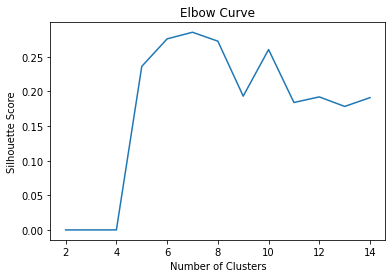

In [ ]:
# PLOT the cosines

import pylab as pl
pl.plot(df_clusterSize.cluster, df_clusterSize.cosine)
pl.xlabel('Number of Clusters')
pl.ylabel('Silhouette Score')
pl.title('Elbow Curve')
pl.show()

In [ ]:
predictions.show()

+--------------------+--------------------+----------+
|                text|            features|prediction|
+--------------------+--------------------+----------+
|                text|[0.0,0.0,0.0,0.0,...|         0|
|Serum Institute O...|[0.08654927176670...|         0|
|10 centres short ...|[-0.0512182234762...|         0|
|Serum Institute O...|[-0.0209223019045...|         0|
|     What about this|[-0.5699329986883...|        11|
|AstraZeneca vacci...|[-0.2260921952385...|        12|
|                   "|[-0.5699329986883...|        11|
|Oxford University...|[0.13859190578427...|         0|
|COVID19 Vaccine U...|[-0.1591613315153...|        12|
|Hopes for our fut...|[0.0,0.0,0.0,0.0,...|         0|
|CovidVaccine Bill...|[-0.4248171621771...|        12|
|Bill Gates Spendi...|[-0.0915733827183...|         0|
|CovidVaccine  Rus...|[-0.1365770536064...|        13|
| AstraZeneca Covi...|[-0.2134449347830...|         3|
| Thats one good r...|[-0.2434939249709...|         3|
|Serum Ins

In [ ]:
predictions.filter("prediction=6").show(50, truncate=False)

+---------------------------------------------------+-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+----------+
|text                                               |features                                                                                                                                                                                                           |prediction|
+---------------------------------------------------+-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+----------+
|AstraZeneca CovidVaccine QuickTake                 |[-0.5042872232435108,-0.4244550587161168,-0.09282570179091675,0.09685284144724195,0.04865785002721759,7.357510826703